In [ ]:
!pip install numpy==1.22.0 catboost==1.1.1 etna==2.0.0 pandas==1.5.3 pandas-profiling==3.6.6

In [40]:
from pathlib import Path
import pandas as pd
from etna.datasets.tsdataset import TSDataset
import warnings
warnings.filterwarnings("ignore")

In [41]:
def merge_data(path, TRAIN_CHECK):

    # считывание всех датафреймов
    chmf = pd.read_csv(path + 'CHMF Акции.csv')
    magn = pd.read_csv(path + 'MAGN Акции.csv')
    nkml = pd.read_csv(path + 'NLMK Акции.csv')
    if (TRAIN_CHECK):
        train = pd.read_excel(path + 'train.xlsx')
    else:
        train = pd.read_excel(path + 'test.xlsx')
    gruz = pd.read_excel(path + 'Грузоперевозки.xlsx')
    stroy = pd.read_excel(path + 'Данные рынка стройматериалов.xlsx')
    lme = pd.read_excel(path + 'Индекс LME.xlsx')
    macro = pd.read_excel(path + 'Макропоказатели.xlsx')
    metall = pd.read_excel(path + 'Показатели рынка металла.xlsx')
    toplivo = pd.read_excel(path + 'Топливо.xlsx')
    price = pd.read_excel(path + 'Цены на сырье.xlsx')

    # исправим ошибку в колонке, чтобы считывалось как pd.date_time
    magn['Дата'] = pd.to_datetime(magn['Дата'], format='%d.%m.%Y')

    # переиминуем колонки
    chmf['Date'] = chmf['Date'].astype('datetime64')
    magn['Date'] = magn['Дата'].astype('datetime64')
    nkml['Date'] = nkml['Date'].astype('datetime64')
    train['Date'] = train['dt'].astype('datetime64')
    gruz['Date'] = gruz['dt'].astype('datetime64')
    stroy['Date'] = stroy['dt'].astype('datetime64')
    # lme['Date'] = lme['дата'].astype('datetime64')
    # macro['Date'] = macro['dt'].astype('datetime64')features_train_df = pd.read_csv(PATH + "train_merged.csv")
# features_test_df = pd.read_csv(PATH + "test_fixed.csv")

    metall['Date'] = metall['dt'].astype('datetime64')
    toplivo['Date'] = toplivo['dt'].astype('datetime64')
    price['Date'] = price['dt'].astype('datetime64')

    # изменяем временные колонки, чтобы не залезать в будущее
    stroy['Date'] = stroy['Date'] + pd.DateOffset(months=1)
    metall['Date'] = metall['Date'] + pd.DateOffset(months=1)
    toplivo['Date'] = toplivo['Date'] + pd.DateOffset(months=1)
    gruz['Date'] = gruz['Date'] + pd.DateOffset(weeks=1)
    price['Date'] = price['Date'] + pd.DateOffset(weeks=1)

    # приведем к единому стандарту таблицы с акнциями
    nkml.rename({'Price': 'Price_NLMK',
             'Open': 'Open_NLMK',
             'High.': 'High_NLMK',
             'Low': 'Low_NLMK',
             'Vol.': 'Vol._NLMK',
             'Change %': 'Change %_NLMK'
             }, axis=1, inplace=True)

    chmf.rename({'Price': 'Price_CHMF',
                'Open': 'Open_CHMF',
                'High.': 'High_CHMF',
                'Low': 'Low_CHMF',
                'Vol.': 'Vol._CHMF',
                'Change %': 'Change %_CHMF'
                }, axis=1, inplace=True)


    magn.rename({'Цена': 'Price_MAGN',
                'Откр.': 'Open_MAGN',
                'Макс.': 'High_MAGN',
                'Мин.': 'Low_MAGN',
                'Объём': 'Vol._MAGN',
                'Изм. %': 'Change %_MAGN'
                }, axis=1, inplace=True)
    magn.drop('Дата', axis=1, inplace=True)

    # объединим таблички
    data = pd.merge(nkml, chmf, on='Date')
    data = pd.merge(data, magn, on='Date')

    # СОХРАНИЛИ АКЦИИ
    actions = data

    # Объеденим Metall+train + toplivo + stroy (месяца)
    # Metall
    metall['month'] = (metall['Date'].dt.month).astype(str)
    metall['year'] = (metall['Date'].dt.year).astype(str)
    metall['date_concat'] = metall['year'] + '_' + metall['month']
    metall.drop(['month', 'year'], axis=1, inplace=True)

    # Train
    train['month'] = (train['Date'].dt.month).astype(str)
    train['year'] = (train['Date'].dt.year).astype(str)
    train['date_concat'] = train['year'] + '_' + train['month']
    train.drop(['month', 'year'], axis=1, inplace=True)

    # Stroy
    stroy['month'] = (stroy['Date'].dt.month).astype(str)
    stroy['year'] = (stroy['Date'].dt.year).astype(str)
    stroy['date_concat'] = stroy['year'] + '_' + stroy['month']
    stroy.drop(['month', 'year'], axis=1, inplace=True)

    # Toplivo
    toplivo['month'] = (toplivo['Date'].dt.month).astype(str)
    toplivo['year'] = (toplivo['Date'].dt.year).astype(str)
    toplivo['date_concat'] = toplivo['year'] + '_' + toplivo['month']
    toplivo.drop(['month', 'year'], axis=1, inplace=True)

    # Metall + train
    metall_train = pd.merge(train, metall, left_on="date_concat", right_on='date_concat', how="left")
    metall_train.drop(['dt_x', 'dt_y', 'Date_y'], axis=1, inplace=True)
    metall_train.rename({'Date_x': 'Date'}, axis=1, inplace=True)
    metall_train.rename({'Date_x': 'Date'}, axis=1, inplace=True)

    # Metall + train + stroy
    metall_train_stroy = pd.merge(metall_train, stroy, left_on="date_concat", right_on='date_concat', how="left")
    metall_train_stroy.drop(['Date_y'], axis=1, inplace=True)
    metall_train_stroy.rename({'Date_x': 'Date'}, axis=1, inplace=True)
    metall_train_stroy.rename({'Date_x': 'Date'}, axis=1, inplace=True)

    # Metall + train + stroy + toplivo
    metall_train_stroy_toplivo = pd.merge(metall_train_stroy, toplivo, left_on="date_concat", right_on='date_concat', how="left")
    metall_train_stroy_toplivo.drop(['dt_x', 'dt_y', 'Date_y'], axis=1, inplace=True)
    metall_train_stroy_toplivo.rename({'Date_x': 'Date'}, axis=1, inplace=True)
    metall_train_stroy_toplivo.rename({'Date_x': 'Date'}, axis=1, inplace=True)

    # Metall + train + stroy + toplivo + gruz
    metall_train_stroy_toplivo['week'] = (metall_train_stroy_toplivo['Date'].dt.week).astype(str)
    metall_train_stroy_toplivo['year'] = (metall_train_stroy_toplivo['Date'].dt.year).astype(str)
    metall_train_stroy_toplivo['date_concat'] = metall_train_stroy_toplivo['year'] + '_' + metall_train_stroy_toplivo['week']
    metall_train_stroy_toplivo.drop(['week', 'year'], axis=1, inplace=True)

    gruz['week'] = (gruz['Date'].dt.week).astype(str)
    gruz['year'] = (gruz['Date'].dt.year).astype(str)
    gruz['date_concat'] = gruz['year'] + '_' + gruz['week']
    gruz.drop(['week', 'year'], axis=1, inplace=True)

    train_gruz = pd.merge(metall_train_stroy_toplivo, gruz, left_on="date_concat", right_on='date_concat', how="left")
    train_gruz.drop(['Date_y'], axis=1, inplace=True)
    train_gruz.rename({'Date_x': 'Date'}, axis=1, inplace=True)
    train_gruz.rename({'Date_x': 'Date'}, axis=1, inplace=True)

    # Metall + train + stroy + toplivo + gruz + price
    price['week'] = (price['Date'].dt.week).astype(str)
    price['year'] = (price['Date'].dt.year).astype(str)
    price['date_concat'] = price['year'] + '_' + price['week']
    price['date_concat'] = price['date_concat'].drop_duplicates()
    price.drop(['week', 'year'], axis=1, inplace=True)

    train_gruz_price = pd.merge(metall_train_stroy_toplivo, price, left_on="date_concat", right_on='date_concat', how="left")
    train_gruz_price.drop(['Date_y'], axis=1, inplace=True)
    train_gruz_price.rename({'Date_x': 'Date'}, axis=1, inplace=True)
    train_gruz_price.rename({'Date_x': 'Date'}, axis=1, inplace=True)

    # зарахдкодим для train чтобы было 31.12.2018
    if (TRAIN_CHECK):
        for column in price.columns:
            if (column in train_gruz_price.columns) and (column != 'Date'):
                train_gruz_price.loc[208, column] = price[price['Date'] == '2019-01-07'][column].values[0]

    # merge акций
    train = train_gruz_price
    actions[actions.columns[actions.columns.str.contains('MAGN')]] = actions[actions.columns[actions.columns.str.contains('MAGN')]].replace(',', '.', regex=True)
    actions[actions.columns[actions.columns.str.contains('Price')]] = actions[actions.columns[actions.columns.str.contains('Price')]].replace(',', '', regex=True).astype('float')
    actions[actions.columns[actions.columns.str.contains('Low')]] = actions[actions.columns[actions.columns.str.contains('Low')]].replace(',', '', regex=True).astype('float')
    actions[actions.columns[actions.columns.str.contains('High')]] = actions[actions.columns[actions.columns.str.contains('High')]].replace(',', '', regex=True).astype('float')
    actions[actions.columns[actions.columns.str.contains('Open')]] = actions[actions.columns[actions.columns.str.contains('Open')]].replace(',', '', regex=True).astype('float')
    actions['Vol._CHMF'] = actions['Vol._CHMF'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype('float')
    actions['Vol._MAGN'] = actions['Vol._MAGN'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype('float')
    actions['Vol._NLMK'] = actions['Vol._NLMK'].replace(',', '.').replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype('float')
    actions[actions.columns[actions.columns.str.contains('Change')]] = actions[actions.columns[actions.columns.str.contains('Change')]].replace('%', '', regex=True).astype('float')
    actions['Date'] = pd.to_datetime(actions['Date'])

    train['week_number'] = train['Date'].dt.isocalendar().week
    train['year'] = train['Date'].dt.year
    actions['week_number'] = actions['Date'].dt.isocalendar().week
    actions['year'] = actions['Date'].dt.year
    train = actions.merge(train, on='Date', how='outer')
    train.sort_values(by='Date', inplace=True)
    train[actions.drop(columns=['Date', 'week_number', 'year']).columns] = train[actions.drop(columns=['Date', 'week_number', 'year']).columns].fillna(method='ffill')
    train.drop(columns=['week_number_y', 'year_y', 'week_number_x', 'year_x'], inplace=True)
    train.dropna(subset=['Цена на арматуру'], inplace=True)

    #merge lme

    lme.rename(columns={'дата': 'Date', 'цена': 'lme_price'}, inplace=True)
    lme.dropna(inplace=True)
    lme['Date'] = pd.to_datetime(lme['Date'])
    train = lme.merge(train, on='Date', how='outer')
    train.sort_values(by='Date', inplace=True)
    train[lme.drop(columns=['Date']).columns] = train[lme.drop(columns=['Date']).columns].fillna(method='ffill')

    train.dropna(subset=['Цена на арматуру'], inplace=True)

    # merge макропоказатели
    macro['Базовый индекс потребительских цен на товары и услуги']
    macro.rename(columns={'dt': 'Date'}, inplace=True)
    macro['Date'] = pd.to_datetime(macro['Date'])

    macro1 = macro.copy()
    macro1.drop(columns=['Базовый индекс потребительских цен на товары и услуги'], inplace=True)

    train = macro1.merge(train, on='Date', how='outer')
    train.sort_values(by='Date', inplace=True)
    train[macro1.drop(columns=['Date']).columns] = train[macro1.drop(columns=['Date']).columns].fillna(method='ffill')

    macro2 = macro.drop(columns=['Ключевая ставка', 'Курс доллара'])
    macro2['Date'] = macro2['Date'] + pd.DateOffset(months=1)
    macro2['year'] = macro2['Date'].dt.isocalendar().year
    macro2['month'] = macro2['Date'].dt.month

    macro3 = macro2.groupby(['year', 'month']).max().reset_index()
    macro3.drop('Date', inplace=True, axis=1)
    train['year'] = train['Date'].dt.isocalendar().year
    train['month'] = train['Date'].dt.month

    train = train.merge(macro3, on=['year', 'month'], how='outer')

    train.dropna(subset=['Цена на арматуру'], inplace=True)

    train.dropna(subset=['Цена на арматуру'], inplace=True)
    train.drop(columns=['year', 'month', 'date_concat'], inplace=True)
    # train.drop(columns=['dt'], inplace=True)
    train.sort_values(by='Date', inplace=True)

    train.drop(columns=['dt'], inplace=True)
    train.sort_values(by='Date', inplace=True)

    train.to_csv('test_without_actions_lme.csv', index=False)
    return train

In [42]:
PATH = "reinforcement_task/data/"

In [43]:
features_train_df = merge_data(PATH, True)
features_test_df = merge_data(PATH, False)

In [44]:
features_train_df = features_train_df.rename(
    columns={
        "Date": "timestamp",
    }
)
features_train_df["segment"] = 1
features_train_df["timestamp"] = pd.to_datetime(features_train_df["timestamp"])

features_test_df = features_test_df.rename(
    columns={
        "Date": "timestamp",
    }
)
features_test_df["segment"] = 1
features_test_df["timestamp"] = pd.to_datetime(features_test_df["timestamp"])

In [45]:
to_drop = (features_train_df.isna().sum() > 230)

features_train_df = features_train_df.drop(to_drop[to_drop==True].index.values, axis=1)

features_test_df = features_test_df.drop(to_drop[to_drop==True].index.values, axis=1)

In [46]:
features_train_df

,timestamp,Ключевая ставка,Курс доллара,Price_NLMK,Open_NLMK,High_x,Low_NLMK,Vol._NLMK,Change %_NLMK,Price_CHMF,...,"Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т",segment
0,2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2015-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2015-01-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2015-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2015-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,2022-08-01,8.0,61.3101,131.70,131.94,136.36,128.20,10760000.0,1.31,732.0,...,475.0,6778.0,4950.0,2760.0,56.0,74.0,108.0,118.0,178.5,1
1579,2022-08-08,8.0,60.3696,118.74,122.50,122.50,118.08,2960000.0,-1.13,683.6,...,435.0,4602.0,3405.0,1984.0,41.0,51.0,72.0,90.0,159.0,1
1585,2022-08-15,8.0,60.8993,117.96,117.68,117.96,115.70,2900000.0,0.68,708.2,...,420.0,4602.0,3405.0,1984.0,41.0,51.0,72.0,90.0,159.0,1
1591,2022-08-22,8.0,59.1321,116.46,115.10,117.08,114.30,3280000.0,1.36,708.0,...,430.0,4602.0,3405.0,1984.0,41.0,51.0,72.0,90.0,159.0,1


In [47]:
train_df = pd.read_excel(PATH + "train.xlsx")
test_df = pd.read_excel(PATH + "test.xlsx")

def get_ts(df, features_df, known_future="all"):
    df = df.rename(
    columns={
        "dt": "timestamp",
        "Цена на арматуру": "target",
    }
    )
    df["segment"] = 1
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    ts = TSDataset.to_dataset(df[["timestamp", "target", "segment"]])
    features = TSDataset.to_dataset(features_df)
    ts = TSDataset(ts, freq="W-MON",
                df_exog=features
                )
    
    return ts

train_ts = get_ts(train_df.iloc[40:], features_train_df.iloc[40:])
test_ts = get_ts(test_df, features_test_df, ())

In [48]:
from etna.core import load
pipe = load('pipeline.zip', ts=train_ts)

In [49]:
pipe.horizon = 28
for p in pipe.pipelines:
    p.horizon = 28
    
preds = pipe.forecast()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s finished


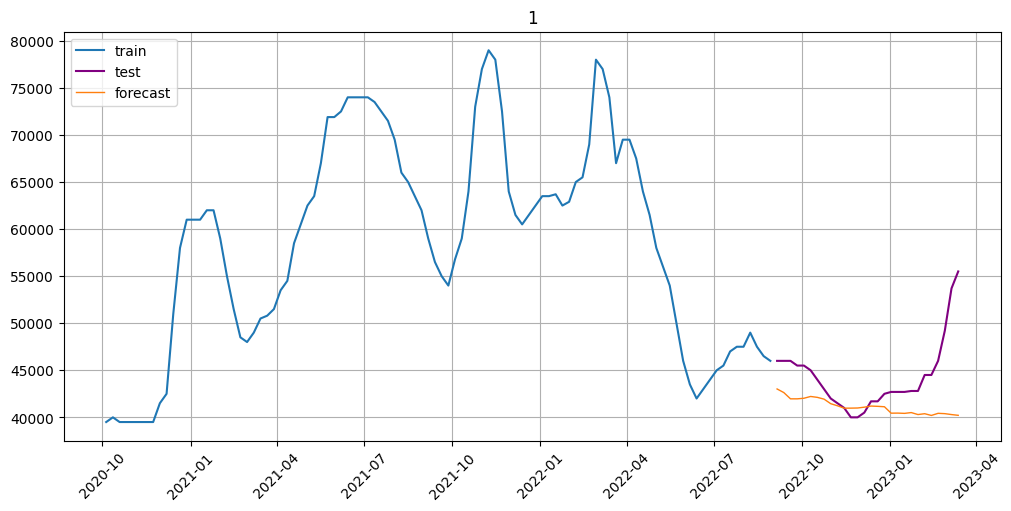

In [50]:
from etna.analysis import plot_forecast
plot_forecast(preds, test_ts, train_ts, n_train_samples=100, figsize=(10, 5))

In [51]:
prices = preds.loc[:, '1']['target']

In [59]:
def calculate_vol(data):
    vol_ans = []
    price = list(data.values)
    price.append(1000000000)

    k = 0
    for i in range(len(price) - 1):
        if (i < k):
            vol_ans.append(0)
            continue

        count = 0
        step = min(11, len(price) - i)
        for j in range(i + 1, i + step):
            count += 1
            if (price[j] <= price[i]):
                break

        if (count != 0):
            k = j
        vol_ans.append(count)

    vol_ans.append(0)
    ans = pd.DataFrame({'dt': data.index.values, 'Объём': vol_ans[:-1], 'Цена на арматуру': price[:-1]})
    
    return ans

In [62]:
prices

timestamp
2022-09-05    43014.893449
2022-09-12    42632.293411
2022-09-19    41966.190645
2022-09-26    41965.171213
2022-10-03    42027.016705
2022-10-10    42217.868528
2022-10-17    42122.500828
2022-10-24    41934.022601
2022-10-31    41448.155247
2022-11-07    41229.303378
2022-11-14    40973.870016
2022-11-21    40977.679217
2022-11-28    40991.862163
2022-12-05    41079.119614
2022-12-12    41197.785329
2022-12-19    41168.083371
2022-12-26    41125.926558
2023-01-02    40442.506660
2023-01-09    40450.050847
2023-01-16    40421.704705
2023-01-23    40505.107147
2023-01-30    40295.396570
2023-02-06    40385.653269
2023-02-13    40201.285275
2023-02-20    40426.428351
2023-02-27    40391.466589
2023-03-06    40294.160547
2023-03-13    40214.234922
Freq: W-MON, Name: target, dtype: float64

In [61]:
volumes = calculate_vol(prices)
volumes.to_excel('submission.xlsx', index=False)